In [5]:
# Find out diamond 11-digit ids in test set

testset_path = '/media/hdd/lingjia/hdd_diamond/cls/data/diamond/exp11/test'

import os

flist = []
for r,d,fs in os.walk(testset_path):
    for f in fs:
        if 'png' in f:
            flist.append(f[:11])

flist = list(set(flist))

with open('/media/hdd/lingjia/hdd_diamond/cls/data/diamond/exp11_test_ids.txt','w') as f:
    for ff in flist:
        f.write(ff+'\n')
        
            

In [11]:
# Copy images to save_path based on id.txt

import os
from shutil import copy2

idfile = '/media/hdd/lingjia/hdd_diamond/cls/data/diamond/test.txt'
data_path = '/media/hdd/diamond/data/hdr_data_v2'
save_path = '/media/hdd/lingjia/hdd_diamond/cls/temp'
os.makedirs(save_path,exist_ok=True)

with open(idfile,'r') as f:
    idlist = f.readlines()
idlist = [n[:-1] for n in idlist]

for r,d,fs in os.walk(data_path):
    for f in fs:
        if f[:11] in idlist and 'png' in f and 'mask' not in f:
            copy2(os.path.join(r,f),os.path.join(save_path,f[:11]+'.png'))
            print(f'{r} {f}')
    


/media/hdd/diamond/data/hdr_data_v2/20200612 60 HDR images and videos (741 - 800)/20200527 CityU VVS2 to SI1 (B) 10376321003(G)-Darkfield-01.png


In [1]:
# Functions for visualization
import os
import numpy as np
import xml.dom.minidom
from PIL import Image, ImageDraw, ImageFont
from skimage.segmentation import mark_boundaries as mkbdy

def MarkBoundary(src_folder,xmlfile,save_folder,is_index=False,fontsize=5,clslist=None):
    """ Mark out multi-class, types of inclusions, inclusion and reflection not distinguished """

    categories_all = {'Burn_mark':0, 'Cloud':1, 'Crystal':2, 'Feather':3, 'Internal_graining':4, 
                  'Needle':5, 'Nick':6, 'Pinpoint':7, 'Pit':8, 'Twinning_wisp':9}

    # Color for Mark Boundary & Legend
    colors_mkbdy = [(1,0,0),(0,1,0),(0,0,1),(1,1,0),(1,0,1),(1,0.5098,0.2784),
                    (0.5451,0.2706,0.0745),(1,0.4157,0.4157),(1,0.7569,0.1451),(0.133,0.545,0.133)]

    if clslist:
        categories = {}
        idx = 0
        for cc in categories_all.keys():
            if cc in clslist:
                categories[cc] = idx
                idx += 1
    else:
        categories = categories_all
    
    # Legend
    if not os.path.exists(os.path.join(save_folder, 'legend.png')):
        print('Create legend...')
        legend = Image.new('RGB', (200,200))
        draw_legend = ImageDraw.Draw(legend)
        row_idx = 10
        for nt, key in enumerate(categories.keys()):
            color = tuple([round(n*255) for n in colors_mkbdy[nt]])
            draw_legend.text((30,row_idx),key,color)
            row_idx += 10
        legend.save(os.path.join(save_folder,'legend.png'))
    else:
        print('Legend exist...')

    dom = xml.dom.minidom.parse(os.path.join(src_folder,xmlfile))
    xml_root = dom.documentElement
    images = xml_root.getElementsByTagName('image')
    
    for ii in range(len(images)):
        t = images[ii]
        t_width = int(t.getAttribute("width"))
        t_height = int(t.getAttribute("height"))
        t_name = t.getAttribute("name").split('/')[-1]

        mask_list = []
        draw_list = []
        for nt in range(len(categories)):
            img_mask = Image.new('L', (int(t_width), int(t_height)))
            draw = ImageDraw.Draw(img_mask)
            mask_list.append(img_mask)
            draw_list.append(draw)

        t_poly = t.getElementsByTagName("polygon") + t.getElementsByTagName("polyline")
        for t_ply in t_poly:
            cls_name = t_ply.getAttribute("label").split('_Reflection')[0]
            if not cls_name in categories.keys():
                # print(f'skip {t_name} {t_ply_label}')
                continue

            t_ply_points = t_ply.getAttribute("points")
            t_ply_points = t_ply_points.split(";")
            t_ply_points = np.asarray([[int(float(b)) for b in a.split(",")] for a in t_ply_points])
            t_x = t_ply_points[:,0]
            t_y = t_ply_points[:,1]
            t_xy = [(x,y) for x,y in zip(t_x,t_y)]

            tmp_draw = draw_list[categories[cls_name]]
            tmp_draw.polygon(t_xy, fill='white')

        mask_np_list = [np.expand_dims(np.array(mask),axis=2) for mask in mask_list]
        mask_np = np.concatenate(mask_np_list,axis=2)
        if np.max(mask_np) == 0:
            print(f'skip {t_name}')
            continue

        try:
            img_name = [n for n in os.listdir(src_folder) if t_name[:11] in n and 'png' in n and not 'mask' in n][0]
            img = Image.open(os.path.join(src_folder,img_name)).convert('RGB').resize((t_width,t_height),Image.LANCZOS)
        except:
            img_name = [n for n in os.listdir(os.path.join(src_folder,'Twinning wisp')) if t_name[:11] in n and 'png' in n][0]
            img = Image.open(os.path.join(src_folder,'Twinning wisp',img_name)).convert('RGB').resize((t_width,t_height),Image.LANCZOS)

        img_np = np.array(img)
        img_mask = img_np
        for ii in range(mask_np.shape[2]):
            img_mask = mkbdy(img_mask,mask_np[:,:,ii],color=colors_mkbdy[ii],outline_color=colors_mkbdy[ii])
        img_mask = Image.fromarray((img_mask*255).astype('uint8'))
    
        if is_index:
            defect_idx = 0
            draw_index = ImageDraw.Draw(img_mask)
            
            t_poly = t.getElementsByTagName("polygon") + t.getElementsByTagName("polyline")
            for t_ply in t_poly:
                t_ply_points = t_ply.getAttribute("points")
                t_ply_points = t_ply_points.split(";")
                t_ply_points = np.asarray([[int(float(b)) for b in a.split(",")] for a in t_ply_points])
                t_x = t_ply_points[:,0]
                t_y = t_ply_points[:,1]
                t_xy = [(x,y) for x,y in zip(t_x,t_y)]
                draw_index.text(t_xy[-1], str(defect_idx),align ="left")   
                defect_idx = defect_idx + 1

        img_mask.save(os.path.join(save_folder, t_name[:11]+'_vis.png'))
        print(t_name[:11] + ' saved ...')


def checkXML(filelist):
    status = None
    for f in filelist:
        if f.split('.')[-1] == 'xml':
            status = f
    return status

In [ ]:
# Visualization
import os

data_path = '/media/hdd/diamond/data/hdr_data_v2'
save_path = '/media/hdd/diamond/data/imgs_vis'
os.makedirs(save_path,exist_ok=True)

for r,d,fs in os.walk(data_path):
    status = checkXML(fs)
    if status:
        ## mark boundaries of defects on original image and save to save_path, 
        ## for all images in data_path and all types of defects.
        MarkBoundary(r,os.path.join(r,status),save_path,is_index=True,fontsize=5)
        ## specify classes in clslist
        # MarkBoundary(r,os.path.join(r,status),save_path,is_index=True,fontsize=5,clslist=['Cloud','Crystal'])


In [12]:
# Count numbers of defects
from collections import defaultdict
import os
import xml.dom.minidom

def checkXML(filelist):
	status = None
	for f in filelist:
		if f.split('.')[-1] == 'xml':
			status = f
	return status

def count_inclusions(data_path):
	types = []
	count_dict = defaultdict(int)
	for root,dirs,files in os.walk(data_path):
		status = checkXML(files)
		if status is not None:
			dom = xml.dom.minidom.parse(os.path.join(root,status))
			xml_root = dom.documentElement
			images = xml_root.getElementsByTagName('image')
			for t in images:
				t_polygon = t.getElementsByTagName("polygon") + t.getElementsByTagName("polyline")
				for t_plg in t_polygon:
					t_plg_label = t_plg.getAttribute("label")
					count_dict[t_plg_label]=count_dict[t_plg_label]+1
					if t_plg_label not in types:
							types.append(t_plg_label)
	return count_dict


data_path = '/media/hdd/diamond/data/hdr_data_v2'
count_dict = count_inclusions(data_path)
sorted_dict = dict(sorted(count_dict.items()))
print(sorted_dict)

{'Burn_mark': 1, 'Cloud': 2506, 'Cloud_Reflection': 10926, 'Crystal': 2622, 'Crystal_Reflection': 15680, 'Feather': 584, 'Feather_Reflection': 801, 'Internal_graining': 2044, 'Internal_graining_Reflection': 4, 'Needle': 140, 'Needle_Reflection': 402, 'Nick': 3, 'Nick_Reflection': 3, 'Pinpoint': 5596, 'Pinpoint_Reflection': 15495, 'Pit': 1, 'Twinning_wisp': 375, 'Twinning_wisp_Reflection': 1470}


In [7]:
# Remove special cases
import os
from shutil import copy2, move

img_list = ['10377322674','10377900198']
# data_path = '/media/hdd/lingjia/hdd_diamond/cls/data/diamond/exp11'
# save_path = '/media/hdd/lingjia/hdd_diamond/cls/data/diamond/exp11/special_cases'
data_path = '/media/hdd/Bella/diamond_preprocessed/upscaled_diamond'
save_path = '/media/hdd/Bella/diamond_preprocessed/upscaled_diamond/special_cases'
os.makedirs(save_path,exist_ok=True)

for r,d,fs in os.walk(data_path):
    for f in fs:
        if f[:11] in img_list:  # if 'special' not in r and 
            print(r,f)
            move(os.path.join(r,f),os.path.join(save_path,f))

PermissionError: [Errno 13] Permission denied: '/media/hdd/Bella/diamond_preprocessed/upscaled_diamond/special_cases'

In [ ]:
# Comparision of Gigapixel & nearest interpolation
import os
from shutil import copy2
from PIL import Image
import torchvision.transforms as transforms
resize = transforms.Resize([224,224])

img_list= ['10349677844_3','10349677844_180','10351385380_3','10352013444_27',
           '10352757648_4','10352960524_101','10359074791_56','10361250493_42',
           '10363313859_85','10367179278_72']
giga_path = '/media/hdd/Bella/diamond_preprocessed/upscaled_testData/test'
ori_path = '/media/hdd/lingjia/hdd_diamond/cls/data/diamond/exp11/test'
save_path = '/media/hdd/lingjia/hdd_diamond/cls/data/ex/gigapixel_builtin_interpolation'
os.makedirs(save_path,exist_ok=True)

for r,d,fs in os.walk(ori_path):
    for f in fs:
        if f[:-4] in img_list:
            print(f)
            clsn = r.split('/')[-1]
            # original image
            copy2(os.path.join(r,f),os.path.join(save_path,f))
            img = Image.open(os.path.join(r,f))
            # gigapixel
            copy2(os.path.join(giga_path,clsn,f[:-4]+'_4X.png'),os.path.join(save_path,f[:-4]+'_v1_giga.png'))
            giga = Image.open(os.path.join(giga_path,clsn,f[:-4]+'_4X.png'))
            w,h = giga.size
            resize_giga = transforms.Resize([h,w])
            img_giga = resize_giga(img)
            img_giga.save(os.path.join(save_path,f[:-4]+'_v1_bi.png'))
            # interpolation
            img_bi = resize(img)
            img_bi.save(os.path.join(save_path,f[:-4]+'_v2_bi.png'))
            # gigapixel
            giga_bi = resize(giga)
            giga_bi.save(os.path.join(save_path,f[:-4]+'_v2_giga.png'))


-42.5
-43 -42 -44 -43 (309, 311) (224, 224)


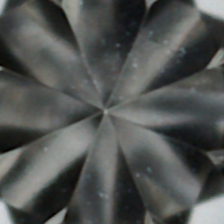

In [5]:
# zero-padding examples 1.zero padding, 2.center crop
from PIL import Image
from math import floor
import numpy as np
import torchvision.transforms as transforms

tar_size = (224,224)

"""zero padding"""
# img_path = '/media/hdd/lingjia/hdd_diamond/cls/data/diamond/exp11/upsample_ex/Crystal/10345339715_4.png'
# img_path = '/media/hdd/lingjia/hdd_diamond/cls/data/diamond/exp11/upsample_ex/Cloud/10283894673_11.png'
# img_path = '/media/hdd/lingjia/hdd_diamond/cls/data/diamond/exp11/train/Cloud/10349677844_47.png'
"""center crop"""
# img_path = '/media/hdd/lingjia/hdd_diamond/cls/data/ex/20221026_cloud_ori_downsample/10376464572_2.png'
img_path = '/media/hdd/lingjia/hdd_diamond/cls/data/ex/20221026_cloud_ori_downsample/10380341592_11.png'

image = Image.open(img_path)
w,h = image.size
lp = (tar_size[0]-w)/2
rp = lp
if not lp%1==0:
    print(lp)
    lp = floor(lp)
    rp = lp + 1
up = (tar_size[1]-h)/2
dp = up
if not up%1==0:
    up = floor(up)
    dp = up + 1

# RGB = np.pad(image, pad_width=[(6, 6),(6, 6),(0, 0)], mode='constant')
padding = transforms.Pad(padding=(int(lp),int(up),int(rp),int(dp)),fill=0,padding_mode='constant')
pp = padding(image)
# pp = image

# tt = transforms.RandomChoice([transforms.RandomRotation(30),transforms.RandomVerticalFlip(0.5),transforms.RandomHorizontalFlip(0.5)])
# pp = tt(pp)

# Method 2
# p = Image.new('RGB', tar_size, (0, 0, 0))
# p.paste(image, (lp, up, w+lp, h+up))

image.save('/media/hdd/lingjia/hdd_diamond/cls/data/ex/20221028_zero_padding_ex/10380341592_11_cloud.png')
pp.save('/media/hdd/lingjia/hdd_diamond/cls/data/ex/20221028_zero_padding_ex/10380341592_11_cloud_crop.png')

print(f"{lp} {rp} {up} {dp} {image.size} {pp.size}")
pp.size
pp


In [1]:
# Check correspondence between original and super-resolution dataset
import os

sr_path = '/media/hdd/Bella/diamond_preprocessed/upscaled_diamond'
ori_path = '/media/hdd/lingjia/hdd_diamond/cls/data/diamond/exp11'
# phases = ['train','val','test']
# clss = ['Cloud','Crystal','Feather','Twinning_wisp']
phases = ['train']
clss = ['Crystal']

for phase in phases:
    for c in clss:
        print(phase,c)
        srpath = os.path.join(sr_path,phase,c)
        srlist = [n.split('_4X')[0] for n in os.listdir(srpath)]
        srlist.sort()
        # print(f'len: {len(srlist)} ex: {srlist[:3]}')
        
        oripath = os.path.join(ori_path,phase,c)
        orilist = [n.split('.')[0] for n in os.listdir(oripath)]
        # orilist = os.listdir(oripath)
        orilist.sort()
        # print(f'len: {len(orilist)} {orilist[:3]}')
        
        print(f'len ori: {len(orilist)} sr: {len(srlist)}')

        retD1 = list(set(orilist).difference(set(srlist)))
        retD2 = list(set(srlist).difference(set(orilist)))
        retD = retD1 + retD2
        print(retD[:5])
        print(len(retD))
        retD_short = [n[:11] for n in retD]
        retD_short = list(set(retD_short))
        print(retD_short)


for phase in phases:
    for c in clss:
        print(phase,c)
        srpath = os.path.join(sr_path,phase,c)
        srlist = [n.split('_')[0] for n in os.listdir(srpath)]
        srlist = list(set(srlist))
        # print(f'len: {len(srlist)} ex: {srlist[:3]}')
        
        oripath = os.path.join(ori_path,phase,c)
        orilist = [n.split('_')[0] for n in os.listdir(oripath)]
        # orilist = os.listdir(oripath)
        orilist = list(set(orilist))
        # print(f'len: {len(orilist)} {orilist[:3]}')
        
        for img in retD_short:
            if img in srlist and img in orilist:
                print(f'{img} 1 2')
            elif img in orilist:
                print(f'{img} 1')
            elif img in srlist:
                print(f'{img} 2')
            else:
                print(f'{img}')


train Crystal
len ori: 14580 sr: 14630
['10377322674_25', '10377322674_20', '10377322674_66', '10377322674_69', '10377322674_57']
50
['10377322674']
train Crystal
10377322674 2


In [ ]:
# Count Cut sample size - from Bella 2022-11-02
#count image size
from PIL import Image
import os
import pickle

img_dir = '/media/hdd/Bella/diamond_preprocessed/testData/test/'
save_dir ='/media/hdd/Bella/diamond_preprocessed/testData/count_test_size/'

classes = ["Cloud","Crystal","Feather","Twinning_wisp"]
'''
img_size_dict = {'less than 56*56':{classes[0]:[], classes[1]:[], classes[2]:[], classes[3]:[]},
                          'less than 56*224':{classes[0]:[], classes[1]:[], classes[2]:[], classes[3]:[]},
                          'less than 224*224':{classes[0]:[], classes[1]:[], classes[2]:[], classes[3]:[]},
                          'larger than 224*224':{classes[0]:[], classes[1]:[], classes[2]:[], classes[3]:[]}}

for cls_num in range(len(classes)):
    img_file = img_dir + classes[cls_num]
    img_list = os.listdir(img_file)
    for imgN in img_list:
        img = Image.open(img_file+'/'+imgN)
        w = img.width
        h = img.height
        if w<=56 and h<=56:
            img_size_dict['less than 56*56'][classes[cls_num]].append(imgN)
        elif (w<=56 and h<=224) or (w<=224 and h<=56):
            img_size_dict['less than 56*224'][classes[cls_num]].append(imgN)
        elif w<=224 and h<=224:
            img_size_dict['less than 224*224'][classes[cls_num]].append(imgN)
        else:
            img_size_dict['larger than 224*224'][classes[cls_num]].append(imgN)

# save
f_save = open(save_dir+'count_size_classes.pkl', 'wb')
pickle.dump(img_size_dict, f_save)
f_save.close()
 
# # read
f_read = open(save_dir+'count_size_classes.pkl', 'rb')
dict2 = pickle.load(f_read)
print(dict2['larger than 224*224'][classes[3]])

print("The number of images in less than 56*56 is: {}, {}, {}, {}".format(len(img_size_dict['less than 56*56'][classes[0]]), len(img_size_dict['less than 56*56'][classes[1]]),len(img_size_dict['less than 56*56'][classes[2]]),len(img_size_dict['less than 56*56'][classes[3]])))
print("The number of images in less than 56*224 is: {}, {}, {}, {}".format(len(img_size_dict['less than 56*224'][classes[0]]),len(img_size_dict['less than 56*224'][classes[1]]),len(img_size_dict['less than 56*224'][classes[2]]),len(img_size_dict['less than 56*224'][classes[3]])))
print("The number of images in less than 224*224 is: {}, {}, {}, {}".format(len(img_size_dict['less than 224*224'][classes[0]]),len(img_size_dict['less than 224*224'][classes[1]]),len(img_size_dict['less than 224*224'][classes[2]]),len(img_size_dict['less than 224*224'][classes[3]])))
print("The number of images in larger than 224*224 is: {}, {}, {}, {}".format(len(img_size_dict['larger than 224*224'][classes[0]]),len(img_size_dict['larger than 224*224'][classes[1]]),len(img_size_dict['larger than 224*224'][classes[2]]),len(img_size_dict['larger than 224*224'][classes[3]])))
'''
img_size_dict = {'less than 56*56':[],'less than 56*224':[],'less than 224*224':[],'larger than 224*224':[]}
for cls_num in range(len(classes)):
    img_file = img_dir + classes[cls_num]
    img_list = os.listdir(img_file)
    for imgN in img_list:
        img = Image.open(img_file+'/'+imgN)
        w = img.width
        h = img.height
        if w<=56 and h<=56:
            img_size_dict['less than 56*56'].append(imgN)
        elif (w<=56 and h<=224) or (w<=224 and h<=56):
            img_size_dict['less than 56*224'].append(imgN)
        elif w<=224 and h<=224:
            img_size_dict['less than 224*224'].append(imgN)
        else:
            img_size_dict['larger than 224*224'].append(imgN)

# save
f_save = open(save_dir+'count_size_classes_0.pkl', 'wb')
pickle.dump(img_size_dict, f_save)
f_save.close()
 
# # read
f_read = open(save_dir+'count_size_classes_0.pkl', 'rb')
dict2 = pickle.load(f_read)
print(dict2['larger than 224*224'])

print("The number of images in less than 56*56 is: {}".format(len(img_size_dict['less than 56*56'])))
print("The number of images in less than 56*224 is: {}".format(len(img_size_dict['less than 56*224'])))
print("The number of images in less than 224*224 is: {}".format(len(img_size_dict['less than 224*224'])))
print("The number of images in larger than 224*224 is: {}".format(len(img_size_dict['larger than 224*224'])))


In [6]:
# Diff two files
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 25 11:47:28 2021

@author: DAILingjia
"""
import sys
import difflib
import os
 
 
def readfile(file1):
    try:
        fd=open(file1,"r")
        text=fd.read().splitlines()  #读取之后进行行分割
        return text
    except Exception as e:
        print("read file error")
        print(e)
        sys.exit()
 
 
 
def Compare(file_1,file_2,path):
    if file_1 =="" or file_2 == "":
        print("file 1 or file 2 not empty")
        sys.exit()
 
    text1=readfile(file_1)
    text2=readfile(file_2)
 
    diff=difflib.HtmlDiff() #创建一个diff对象
    result=diff.make_file(text1,text2)  #得出比较结果
 
    try:
        fd_diff=open(os.path.join(path,"diff.html"),"w")
        fd_diff.write(result)
 
    except Exception as e:
        print("write html file error")
        print(e)
        sys.exit()
 
 

path = '/home/lingjia/Documents/diamond/cls_resnet_weightedsampler_1vsall'
file1 = os.path.join(path, 'main_old.py')
file2 = os.path.join(path, 'main_trainvalsame.py')
Compare(file1, file2, path)